In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.ao.nn.quantized import functional as qF
import numpy as np
import cv2 as cv
import pytorch_lightning as pl
import torchvision
import torchvision.transforms.v2 as transforms
from torcheval.metrics import MulticlassAccuracy
from torcheval.metrics.functional import multiclass_accuracy
from torch.ao.quantization import QuantStub, DeQuantStub
import json

from models import DatasetWrapper, MyMobileNet, SeparableConv2d, get_dataloaders

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

trainloader, validloader, testloader = get_dataloaders(batch_size=512, num_workers=24)

/home/semar/.local/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


# Training zk-MobileNet

In [37]:
class SeparableConv2d(nn.Module):
    '''Separable convolution'''
    def __init__(self, in_channels, out_channels, stride=1):
        super(SeparableConv2d, self).__init__()
        self.dw_conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=0, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            # nn.ReLU(inplace=False),
        )
        self.pw_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            # nn.ReLU(inplace=False),
        )

    def forward(self, x):
        # print("SEP CONV INPUT SHAPE: ", x.shape)
        x = self.dw_conv(x)
        # print("DEPTHWISE CONV SHAPE: ", x.shape)
        x = self.pw_conv(x)
        # print("POINTWISE CONV SHAPE: ", x.shape)
        return x
        
class ZkMobileNet(pl.LightningModule):
    cfg = [
        (32, 64, 1), 
        (64, 128, 1), 
        (128, 128, 1), 
        (128, 256, 1),
        (256, 256, 1),
        (256, 512, 1),
        (512, 512, 1),
        (512, 512, 1),
        (512, 512, 1),
        (512, 512, 1),
        (512, 512, 1),
        (512, 1024, 1),
        (1024, 1024, 1),
    ]
    
    def __init__(self, steps_per_epoch, num_classes: int=10, alpha: float=1, max_epochs: int=50):
        super(ZkMobileNet, self).__init__()
        conv_out = int(32 * alpha)
        self.conv = nn.Conv2d(3, conv_out, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(conv_out)
        self.relu = nn.ReLU(inplace=False)
        self.max_epochs = max_epochs
        self.steps_per_epoch = steps_per_epoch
        self.accuracy = multiclass_accuracy

        self.features = self.make_feature_extractor(alpha)
        self.linear = nn.Linear(int(1024*alpha), num_classes)

    def make_feature_extractor(self, alpha):
        layer_values = [(int(inp*alpha), int(out*alpha), chan) for inp, out, chan in self.cfg]
        layers = nn.Sequential(*[SeparableConv2d(*tup) for tup in layer_values])
        return layers

    def forward(self, x):
        # print("STARTING SHAPE: ", x.shape)
        x = self.relu(self.bn(self.conv(x)))
        # print("CONV1 SHAPE: ", x.shape)
        x = self.features(x)
        x = self.relu(x)
        # print("BACKBONE SHAPE: ", x.shape)
        x = F.avg_pool2d(x, 6)
        x = x.view(x.size()[0], -1)
        # print("PRE-CLASSIFIER SHAPE: ", x.shape)
        x = self.linear(x)
        # print("POST-CLASSIFIER SHAPE: ", x.shape)
        return x
        
    def step(self, batch):
        x, y = batch
        logits = self.forward(x)
        loss = self.compute_loss(logits, y)
        acc = self.accuracy(logits, y)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.step(batch)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
        
    def validation_step(self, batch, batch_idx):
        loss, acc = self.step(batch)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
        
    def test_step(self, batch, batch_idx):
        loss, acc = self.step(batch)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
        
    def configure_optimizers(self):
        # Torch find_lr suggestion
        self.lr = 0.02089
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.001, weight_decay=0.001)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.3, total_steps=self.max_epochs * self.steps_per_epoch)
        return { "optimizer": optimizer, "lr_scheduler": scheduler }
        
    def compute_loss(self, logits, labels):
        return nn.functional.cross_entropy(logits, labels)


Files already downloaded and verified
STARTING SHAPE:  torch.Size([1, 3, 32, 32])
CONV1 SHAPE:  torch.Size([1, 8, 32, 32])
SEP CONV INPUT SHAPE:  torch.Size([1, 8, 32, 32])
DEPTHWISE CONV SHAPE:  torch.Size([1, 8, 30, 30])
POINTWISE CONV SHAPE:  torch.Size([1, 16, 30, 30])
SEP CONV INPUT SHAPE:  torch.Size([1, 16, 30, 30])
DEPTHWISE CONV SHAPE:  torch.Size([1, 16, 28, 28])
POINTWISE CONV SHAPE:  torch.Size([1, 32, 28, 28])
SEP CONV INPUT SHAPE:  torch.Size([1, 32, 28, 28])
DEPTHWISE CONV SHAPE:  torch.Size([1, 32, 26, 26])
POINTWISE CONV SHAPE:  torch.Size([1, 32, 26, 26])
SEP CONV INPUT SHAPE:  torch.Size([1, 32, 26, 26])
DEPTHWISE CONV SHAPE:  torch.Size([1, 32, 24, 24])
POINTWISE CONV SHAPE:  torch.Size([1, 64, 24, 24])
SEP CONV INPUT SHAPE:  torch.Size([1, 64, 24, 24])
DEPTHWISE CONV SHAPE:  torch.Size([1, 64, 22, 22])
POINTWISE CONV SHAPE:  torch.Size([1, 64, 22, 22])
SEP CONV INPUT SHAPE:  torch.Size([1, 64, 22, 22])
DEPTHWISE CONV SHAPE:  torch.Size([1, 64, 20, 20])
POINTWISE CO

tensor([[[[-1.0701, -0.1527,  1.4769,  0.1040, -0.0797, -0.5202],
          [-0.7350,  0.5125,  0.5295, -0.5883, -0.1793, -1.2079],
          [ 0.9071, -0.6586, -0.7608,  1.2582, -0.4338,  0.9273],
          [ 1.3003,  0.0912,  0.0653,  1.4027, -1.3639, -0.4768],
          [ 1.3213, -1.6373,  0.8922, -0.1902, -2.1777,  0.3173],
          [ 2.3621,  1.1799, -0.5349, -0.1951, -1.2885, -0.3970]],

         [[-0.5920, -1.3990,  0.0460,  0.1695, -0.0822,  0.9716],
          [-0.1899, -1.0449,  0.0710,  1.5851,  1.1858,  0.2977],
          [-1.9572, -1.0630,  0.5943,  0.0600,  1.8525,  0.0431],
          [-1.2323,  1.1288, -0.2143,  0.0055, -1.1299,  0.5810],
          [-1.9847,  0.0370,  1.4152, -0.4630, -1.8931, -0.2137],
          [ 1.7419,  0.2304,  0.7981, -0.4012,  0.2527,  0.7934]],

         [[-1.2642,  2.0639,  1.2149,  0.1320,  0.6583, -0.6595],
          [-0.7243, -0.2861, -0.4794,  0.2234,  1.2042, -1.4458],
          [ 1.1233,  1.6678, -0.2049, -0.0354, -0.1073, -0.8382],
      

In [38]:
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar

MAX_EPOCHS = 100

model = ZkMobileNet(len(trainloader), num_classes=10, alpha=0.25)

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints/',
    filename='baseline-{epoch:02d}-{val_accuracy:.2f}'
)
progress_callback = RichProgressBar(leave=True)


trainer = pl.Trainer(max_epochs=MAX_EPOCHS, callbacks=[checkpoint_callback, progress_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dataloaders=trainloader, val_dataloaders=validloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name     ┃ Type        ┃ Params ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ conv     │ Conv2d      │    216 │
│ 1 │ bn       │ BatchNorm2d │     16 │
│ 2 │ relu     │ ReLU        │      0 │
│ 3 │ features │ Sequential  │  212 K │
│ 4 │ linear   │ Linear      │  2.6 K │
└───┴──────────┴─────────────┴────────┘

Trainable params: 215 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 215 K                                                                                                
Total estimated model params size (MB): 0

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [13]:
trainer.test(model, testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.6643999814987183     │
│         test_loss         │    1.0078178644180298     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.0078178644180298, 'test_accuracy': 0.6643999814987183}]

In [15]:
MODEL_WEIGHTS_PATH = './checkpoints/model_small_100epochs.pth'
QUANTIZED_MODEL_WEIGHTS_PATH = './checkpoints/quantized_small_100epochs.pth'

In [16]:
print('==> saving model')
state = {
    'net': model.state_dict(),
    'acc': '0.747299',
    'epoch': 50,
}

torch.save(state, MODEL_WEIGHTS_PATH)

==> saving model


In [17]:
# Sanity test

saved = torch.load(MODEL_WEIGHTS_PATH)
# model.load_state_dict(saved['state_dict'])
model.load_state_dict(saved['net'])
trainer.test(model, testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7817999720573425     │
│         test_loss         │    0.6467439532279968     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6467439532279968, 'test_accuracy': 0.7817999720573425}]

# Post Training Quantization!

In [19]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')


class QuantizedMobileNet(MyMobileNet):
    def __init__(self, num_classes=10, alpha: float = 1):
        super(QuantizedMobileNet, self).__init__(num_classes, alpha)
        self.quant = torch.ao.quantization.QuantStub()
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.conv(x)
        x = self.relu(self.bn(x))
        x = self.features(x)
        x = F.avg_pool2d(x, 2)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)
        x = self.dequant(x)
        return x
        
    def training_step(self, batch, batch_idx):
    # def training_step(self):
        loss, acc = self.step(batch, batch_idx)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def load_quantized(self, fp_weights_path, quant_weights_path):
        # create fp32 model
        fp_checkpoint = torch.load(fp_weights_path)
        self.load_state_dict(fp_checkpoint['net'])
        
        # quantize it without calibration (weights will not be final)
        self.eval()
        self.fuse_model()
        self.qconfig = torch.quantization.get_default_qconfig('fbgemm')
        torch.ao.quantization.prepare(self, inplace=True)
        torch.quantization.convert(self, inplace=True)
        
        # load the real state dict
        int_checkpoint = torch.load(quant_weights_path)
        self.load_state_dict(int_checkpoint['net'])
        
    def gen_first_layer_input(self, image):
        x = self.quant(image)
        # quantized_image = torch.int_repr(x.squeeze().permute(1, 2, 0)).numpy() # (1, C, H, W) -> (H, W, C)
        quantized_image = torch.int_repr(x.squeeze()).numpy() # (1, C, H, W) -> (H, W, C)
        # quantized_image = torch.int_repr(x).squeeze().numpy() # (1, C, H, W) -> (C, H, W)
        quantized_weights = torch.int_repr(self.conv.weight()).numpy()
        bias = torch.zeros(quantized_weights.shape[0]).numpy().astype(int).tolist()
        out = self.conv(x)
        # print(quantized_image)
        print("INPUT SIZE: ", image.size())
        print("FIRST LAYER OUTPUT SIZE: ", out.size())
        quantized_out = torch.int_repr(out).numpy()
        print("QUANTIZED SHAPE: ", quantized_image.shape)
        print(quantized_weights.shape)
        input_json_path = "input.json"
        with open(input_json_path, "w") as input_file:
            # json.dump({"in": quantized_image.transpose(1, 2, 0).tolist(), # (C, H, W) -> (H, W, C)
            json.dump({"in": quantized_image.tolist(),
                       "weights": quantized_weights.tolist(),
                       "bias": bias,
                       
                      }, input_file)
        output_json_path = "output.json"
        with open(output_json_path, "w") as output_file:
            json.dump({"out": quantized_out.tolist(),
                       
                      }, output_file)

        return quantized_image, quantized_weights, bias, quantized_out
            

    # Fuse Conv+BN and Conv+BN+Relu modules prior to quantization
    # This operation does not change the numerics
    def fuse_model(self, is_qat=False):
        fuse_modules = torch.ao.quantization.fuse_modules_qat if is_qat else torch.ao.quantization.fuse_modules
        fuse_modules(self, ["conv", "bn", "relu"], inplace=True)
        for m in self.modules():
            if type(m) == SeparableConv2d:
                fuse_modules(m.dw_conv, ['0', '1', '2'], inplace=True)
                fuse_modules(m.pw_conv, ['0', '1', '2'], inplace=True)

In [20]:
# Baseline
model = QuantizedMobileNet(num_classes=10, alpha=0.25)
# model = MyMobileNet(num_classes=10, alpha=0.25)
saved = torch.load(MODEL_WEIGHTS_PATH)
# model.load_state_dict(saved['state_dict'])
model.load_state_dict(saved['net'])
print_size_of_model(model)

progress_callback = RichProgressBar(leave=True)

trainer = pl.Trainer(callbacks=[progress_callback])

trainer.test(model, testloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Size (MB): 0.930354


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7817999720573425     │
│         test_loss         │    0.6467439532279968     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6467439532279968, 'test_accuracy': 0.7817999720573425}]

In [21]:
backend = "fbgemm"
# backend = "x86"
model = QuantizedMobileNet(num_classes=10, alpha=0.25)
checkpoint = torch.load(MODEL_WEIGHTS_PATH)
# model.load_state_dict(checkpoint['state_dict'])
model.load_state_dict(checkpoint['net'])
model.eval()

print('Before Training Quantization Prepare: Starting values')
print('\n Starting SeparableConv Block: \n\n', model.features[1].dw_conv)

model.fuse_model()
# model.qconfig = torch.ao.quantization.default_qconfig # This leads to bad results.
print('Before Training Quantization Prepare: Fusing model')
print('\n After fusing SeparableConv Block: \n\n', model.features[1].dw_conv)


model.qconfig = torch.quantization.get_default_qconfig(backend)

print(model.qconfig)

torch.ao.quantization.prepare(model, inplace=True)

# Calibrate first
print('Post Training Quantization Prepare: Inserting Observers')
print('\n SeparableConv Block:After observer insertion \n\n', model.features[1].dw_conv)

progress_callback = RichProgressBar(leave=True)
trainer = pl.Trainer(accelerator="cpu", callbacks=[progress_callback])

trainer.validate(model, validloader)

torch.ao.quantization.convert(model, inplace=True)

print('Post Training Quantization: Convert done')
print('\n SeparableConv Block: After fusion and quantization, note fused modules: \n\n', model.features[1].dw_conv)
print_size_of_model(model)

progress_callback = RichProgressBar(leave=True)
trainer = pl.Trainer(accelerator="cpu", callbacks=[progress_callback])

trainer.validate(model, validloader)
trainer.test(model, testloader)

/home/semar/.local/lib/python3.11/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Before Training Quantization Prepare: Starting values

 Starting SeparableConv Block: 

 Sequential(
  (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
Before Training Quantization Prepare: Fusing model

 After fusing SeparableConv Block: 

 Sequential(
  (0): ConvReLU2d(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16)
    (1): ReLU()
  )
  (1): Identity()
  (2): Identity()
)
QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})
Post Training Quantization Prepare: Inserting Observers

 SeparableConv Block:After observer insertion 

 Sequential(
  (0): ConvReLU2d(
    (0): Conv2d(16, 16, kern

/home/semar/.local/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7907999753952026     │
│         val_loss          │    0.6160761117935181     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Post Training Quantization: Convert done

 SeparableConv Block: After fusion and quantization, note fused modules: 

 Sequential(
  (0): QuantizedConvReLU2d(16, 16, kernel_size=(3, 3), stride=(2, 2), scale=0.10771986842155457, zero_point=0, padding=(1, 1), groups=16)
  (1): Identity()
  (2): Identity()
)
Size (MB): 0.312596


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7892000079154968     │
│         val_loss          │    0.6157554984092712     │
└───────────────────────────┴───────────────────────────┘

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.781000018119812     │
│         test_loss         │    0.6468526721000671     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6468526721000671, 'test_accuracy': 0.781000018119812}]

In [24]:
# from torch.quantization import quantize_fx
import torch.quantization._numeric_suite as ns

float_model = QuantizedMobileNet(num_classes=10, alpha=0.25)
checkpoint = torch.load(MODEL_WEIGHTS_PATH)
# model.load_state_dict(checkpoint['state_dict'])
float_model.load_state_dict(checkpoint['net'])

wt_compare_dict = ns.compare_weights(float_model.state_dict(), model.state_dict())

print('keys of wt_compare_dict:')
print(wt_compare_dict.keys())

print("\nkeys of wt_compare_dict entry for conv1's weight:")
print(wt_compare_dict['conv.weight'].keys())
print(wt_compare_dict['conv.weight']['float'].shape)
print(wt_compare_dict['conv.weight']['quantized'].shape)

keys of wt_compare_dict:
dict_keys(['conv.weight', 'features.0.dw_conv.0.weight', 'features.0.pw_conv.0.weight', 'features.1.dw_conv.0.weight', 'features.1.pw_conv.0.weight', 'features.2.dw_conv.0.weight', 'features.2.pw_conv.0.weight', 'features.3.dw_conv.0.weight', 'features.3.pw_conv.0.weight', 'features.4.dw_conv.0.weight', 'features.4.pw_conv.0.weight', 'features.5.dw_conv.0.weight', 'features.5.pw_conv.0.weight', 'features.6.dw_conv.0.weight', 'features.6.pw_conv.0.weight', 'features.7.dw_conv.0.weight', 'features.7.pw_conv.0.weight', 'features.8.dw_conv.0.weight', 'features.8.pw_conv.0.weight', 'features.9.dw_conv.0.weight', 'features.9.pw_conv.0.weight', 'features.10.dw_conv.0.weight', 'features.10.pw_conv.0.weight', 'features.11.dw_conv.0.weight', 'features.11.pw_conv.0.weight', 'features.12.dw_conv.0.weight', 'features.12.pw_conv.0.weight', 'linear._packed_params._packed_params'])

keys of wt_compare_dict entry for conv1's weight:
dict_keys(['float', 'quantized'])
torch.Size(

In [25]:
def compute_error(x, y):
    Ps = torch.norm(x)
    Pn = torch.norm(x-y)
    return 20*torch.log10(Ps/Pn)

for key in wt_compare_dict:
    print(key, compute_error(wt_compare_dict[key]['float'], wt_compare_dict[key]['quantized'].dequantize()))

conv.weight tensor(2.3216)
features.0.dw_conv.0.weight tensor(6.1244)
features.0.pw_conv.0.weight tensor(6.3102)
features.1.dw_conv.0.weight tensor(4.6555)
features.1.pw_conv.0.weight tensor(4.7725)
features.2.dw_conv.0.weight tensor(4.9734)
features.2.pw_conv.0.weight tensor(2.7868)
features.3.dw_conv.0.weight tensor(2.4760)
features.3.pw_conv.0.weight tensor(2.6041)
features.4.dw_conv.0.weight tensor(5.2781)
features.4.pw_conv.0.weight tensor(2.2081)
features.5.dw_conv.0.weight tensor(2.8028)
features.5.pw_conv.0.weight tensor(1.8732)
features.6.dw_conv.0.weight tensor(4.4694)
features.6.pw_conv.0.weight tensor(1.5951)
features.7.dw_conv.0.weight tensor(-20.3246)
features.7.pw_conv.0.weight tensor(1.7344)
features.8.dw_conv.0.weight tensor(-18.2233)
features.8.pw_conv.0.weight tensor(1.5521)
features.9.dw_conv.0.weight tensor(-21.5950)
features.9.pw_conv.0.weight tensor(1.6208)
features.10.dw_conv.0.weight tensor(-24.6760)
features.10.pw_conv.0.weight tensor(1.3954)
features.11.dw_co

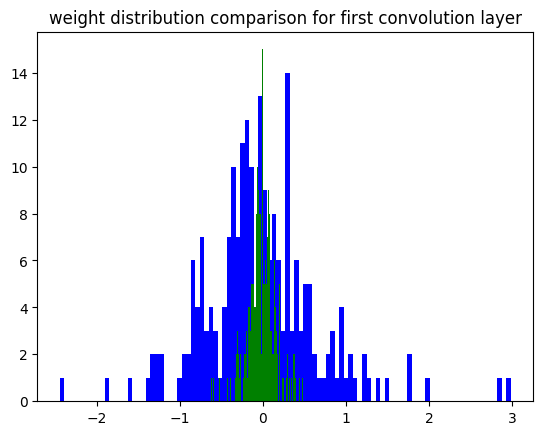

In [26]:
import matplotlib.pyplot as plt

f = wt_compare_dict['conv.weight']['float'].flatten()
plt.hist(f, bins = 100, color='blue')
plt.title("weight distribution comparison for first convolution layer")
# plt.show()

q = wt_compare_dict['conv.weight']['quantized'].dequantize().flatten()
plt.hist(q, bins = 100, color='green')
# plt.title("Quantized model weights of conv")
plt.show()

# Quantization with fusing model

In [12]:
backend = "fbgemm"
# backend = "x86"
model = QuantizedMobileNet()
checkpoint = torch.load(MODEL_WEIGHTS_PATH)
# model.load_state_dict(checkpoint['state_dict'])
model.load_state_dict(checkpoint['net'])
model.eval()
model.fuse_model()
# model.qconfig = torch.ao.quantization.default_qconfig # This leads to bad results.

# model.qconfig = torch.quantization.get_default_qconfig(backend)
model.qconfig = torch.quantization.qconfig.QConfig(activation=torch.quantization.observer.HistogramObserver.with_args(reduce_range=True),
                  weight=torch.quantization.observer.MovingAveragePerChannelMinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_channel_symmetric))
                  # weight=torch.quantization.observer.PerChannelMinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_channel_symmetric))

print(model.qconfig)

torch.ao.quantization.prepare(model, inplace=True)

# Calibrate first
print('Post Training Quantization Prepare: Inserting Observers')
print('\n SeparableConv Block:After observer insertion \n\n', model.features[1].dw_conv)

progress_callback = RichProgressBar(leave=True)
trainer = pl.Trainer(accelerator="cpu", callbacks=[progress_callback])

trainer.validate(model, validloader)

torch.ao.quantization.convert(model, inplace=True)

print('Post Training Quantization: Convert done')
print('\n SeparableConv Block: After fusion and quantization, note fused modules: \n\n', model.features[1].dw_conv)
print_size_of_model(model)

progress_callback = RichProgressBar(leave=True)
trainer = pl.Trainer(accelerator="cpu", callbacks=[progress_callback])

trainer.validate(model, validloader)
trainer.test(model, testloader)

/home/semar/.local/lib/python3.11/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MovingAveragePerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})
Post Training Quantization Prepare: Inserting Observers

 SeparableConv Block:After observer insertion 

 Sequential(
  (0): ConvReLU2d(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64)
    (1): ReLU()
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (1): Identity()
  (2): Identity()
)


/home/semar/.local/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Output()

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([272, 32, 32, 32])

depth conv output:  torch.Size([272, 32, 32, 32])

pointwise conv output:  torch.Size([272, 64, 32, 32])

input:  torch.Size([272, 64, 32, 32])

depth conv output:  torch.Size([272, 64, 16, 16])

pointwise conv output:  torch.Size([272, 128, 16, 16])

input:  torch.Size([272, 128, 16, 16])

depth conv output:  torch.Size([272, 128, 16, 16])

pointwise conv output:  torch.Size([272, 128, 16, 16])

input:  torch.Size([272, 128, 16, 16])

depth conv output:  torch.Size([272, 128, 8, 8])

pointwise conv output:  torch.Size([272, 256, 8, 8])

input:  torch.Size([272, 256, 8, 8])

depth conv output:  torch.Size([272, 256, 8, 8])

pointwise conv output:  torch.Size([272, 256, 8, 8])

input:  torch.Size([272, 256, 8, 8])

depth conv output:  torch.Size([272, 256, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 2, 2])

pointwise conv output:  torch.Size([272, 1024, 2, 2])

input:  torch.Size([272, 1024, 2, 2])

depth conv output:  torch.Size([272, 1024, 2, 2])

pointwise conv output:  torch.Size([272, 1024, 2, 2])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8411999940872192     │
│         val_loss          │     0.473789781332016     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Post Training Quantization: Convert done

 SeparableConv Block: After fusion and quantization, note fused modules: 

 Sequential(
  (0): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(2, 2), scale=0.1215631514787674, zero_point=0, padding=(1, 1), groups=64)
  (1): Identity()
  (2): Identity()
)
Size (MB): 3.461908


Output()

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([272, 32, 32, 32])

depth conv output:  torch.Size([272, 32, 32, 32])

pointwise conv output:  torch.Size([272, 64, 32, 32])

input:  torch.Size([272, 64, 32, 32])

depth conv output:  torch.Size([272, 64, 16, 16])

pointwise conv output:  torch.Size([272, 128, 16, 16])

input:  torch.Size([272, 128, 16, 16])

depth conv output:  torch.Size([272, 128, 16, 16])

pointwise conv output:  torch.Size([272, 128, 16, 16])

input:  torch.Size([272, 128, 16, 16])

depth conv output:  torch.Size([272, 128, 8, 8])

pointwise conv output:  torch.Size([272, 256, 8, 8])

input:  torch.Size([272, 256, 8, 8])

depth conv output:  torch.Size([272, 256, 8, 8])

pointwise conv output:  torch.Size([272, 256, 8, 8])

input:  torch.Size([272, 256, 8, 8])

depth conv output:  torch.Size([272, 256, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 2, 2])

pointwise conv output:  torch.Size([272, 1024, 2, 2])

input:  torch.Size([272, 1024, 2, 2])

depth conv output:  torch.Size([272, 1024, 2, 2])

pointwise conv output:  torch.Size([272, 1024, 2, 2])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8382999897003174     │
│         val_loss          │    0.48289868235588074    │
└───────────────────────────┴───────────────────────────┘

Output()

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([272, 32, 32, 32])

depth conv output:  torch.Size([272, 32, 32, 32])

pointwise conv output:  torch.Size([272, 64, 32, 32])

input:  torch.Size([272, 64, 32, 32])

depth conv output:  torch.Size([272, 64, 16, 16])

pointwise conv output:  torch.Size([272, 128, 16, 16])

input:  torch.Size([272, 128, 16, 16])

depth conv output:  torch.Size([272, 128, 16, 16])

pointwise conv output:  torch.Size([272, 128, 16, 16])

input:  torch.Size([272, 128, 16, 16])

depth conv output:  torch.Size([272, 128, 8, 8])

pointwise conv output:  torch.Size([272, 256, 8, 8])

input:  torch.Size([272, 256, 8, 8])

depth conv output:  torch.Size([272, 256, 8, 8])

pointwise conv output:  torch.Size([272, 256, 8, 8])

input:  torch.Size([272, 256, 8, 8])

depth conv output:  torch.Size([272, 256, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 2, 2])

pointwise conv output:  torch.Size([272, 1024, 2, 2])

input:  torch.Size([272, 1024, 2, 2])

depth conv output:  torch.Size([272, 1024, 2, 2])

pointwise conv output:  torch.Size([272, 1024, 2, 2])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8367999792098999     │
│         test_loss         │    0.5063580274581909     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5063580274581909, 'test_accuracy': 0.8367999792098999}]

In [49]:
print('==> saving quantized model')
state = {
    'net': model.state_dict(),
}

torch.save(state, QUANTIZED_MODEL_WEIGHTS_PATH)

==> saving quantized model


# Quantization without fusing model

In [1587]:
backend = "fbgemm"
# backend = "x86"
model = QuantizedMobileNet(num_classes=10, alpha=0.25)
checkpoint = torch.load(MODEL_WEIGHTS_PATH)
# model.load_state_dict(checkpoint['state_dict'])
model.load_state_dict(checkpoint['net'])
model.eval()

print('Before Training Quantization Prepare: Starting values')
print('\n Starting SeparableConv Block: \n\n', model.features[1].dw_conv)

# model.fuse_model()
# model.qconfig = torch.ao.quantization.default_qconfig # This leads to bad results.
# print('Before Training Quantization Prepare: Fusing model')
# print('\n After fusing SeparableConv Block: \n\n', model.features[1].dw_conv)


model.qconfig = torch.quantization.get_default_qconfig(backend)

print(model.qconfig)

torch.ao.quantization.prepare(model, inplace=True)

# Calibrate first
print('Post Training Quantization Prepare: Inserting Observers')
print('\n SeparableConv Block:After observer insertion \n\n', model.features[1].dw_conv)

progress_callback = RichProgressBar(leave=True)
trainer = pl.Trainer(accelerator="cpu", callbacks=[progress_callback])

trainer.validate(model, validloader)

torch.ao.quantization.convert(model, inplace=True)

print('Post Training Quantization: Convert done')
print('\n SeparableConv Block: After fusion and quantization, note fused modules: \n\n', model.features[1].dw_conv)
print_size_of_model(model)

progress_callback = RichProgressBar(leave=True)
trainer = pl.Trainer(accelerator="cpu", callbacks=[progress_callback])

trainer.validate(model, validloader)
trainer.test(model, testloader)

/home/semar/.local/lib/python3.11/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Before Training Quantization Prepare: Starting values

 Starting SeparableConv Block: 

 Sequential(
  (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})
Post Training Quantization Prepare: Inserting Observers

 SeparableConv Block:After observer insertion 

 Sequential(
  (0): Conv2d(
    16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (1): BatchNorm2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): HistogramO

/home/semar/.local/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Output()

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([272, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([272, 8, 32, 32])

input:  torch.Size([272, 8, 32, 32])

depth conv output:  torch.Size([272, 8, 32, 32])

pointwise conv output:  torch.Size([272, 16, 32, 32])

input:  torch.Size([272, 16, 32, 32])

depth conv output:  torch.Size([272, 16, 16, 16])

pointwise conv output:  torch.Size([272, 32, 16, 16])

input:  torch.Size([272, 32, 16, 16])

depth conv output:  torch.Size([272, 32, 16, 16])

pointwise conv output:  torch.Size([272, 32, 16, 16])

input:  torch.Size([272, 32, 16, 16])

depth conv output:  torch.Size([272, 32, 8, 8])

pointwise conv output:  torch.Size([272, 64, 8, 8])

input:  torch.Size([272, 64, 8, 8])

depth conv output:  torch.Size([272, 64, 8, 8])

pointwise conv output:  torch.Size([272, 64, 8, 8])

input:  torch.Size([272, 64, 8, 8])

depth conv output:  torch.Size([272, 64, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 2, 2])

pointwise conv output:  torch.Size([272, 256, 2, 2])

input:  torch.Size([272, 256, 2, 2])

depth conv output:  torch.Size([272, 256, 2, 2])

pointwise conv output:  torch.Size([272, 256, 2, 2])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.766700029373169     │
│         val_loss          │    0.6789270639419556     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Post Training Quantization: Convert done

 SeparableConv Block: After fusion and quantization, note fused modules: 

 Sequential(
  (0): QuantizedConv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), scale=0.5261287093162537, zero_point=33, padding=(1, 1), groups=16, bias=False)
  (1): QuantizedBatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
Size (MB): 0.389034


Output()

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([272, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([272, 8, 32, 32])

input:  torch.Size([272, 8, 32, 32])

depth conv output:  torch.Size([272, 8, 32, 32])

pointwise conv output:  torch.Size([272, 16, 32, 32])

input:  torch.Size([272, 16, 32, 32])

depth conv output:  torch.Size([272, 16, 16, 16])

pointwise conv output:  torch.Size([272, 32, 16, 16])

input:  torch.Size([272, 32, 16, 16])

depth conv output:  torch.Size([272, 32, 16, 16])

pointwise conv output:  torch.Size([272, 32, 16, 16])

input:  torch.Size([272, 32, 16, 16])

depth conv output:  torch.Size([272, 32, 8, 8])

pointwise conv output:  torch.Size([272, 64, 8, 8])

input:  torch.Size([272, 64, 8, 8])

depth conv output:  torch.Size([272, 64, 8, 8])

pointwise conv output:  torch.Size([272, 64, 8, 8])

input:  torch.Size([272, 64, 8, 8])

depth conv output:  torch.Size([272, 64, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 2, 2])

pointwise conv output:  torch.Size([272, 256, 2, 2])

input:  torch.Size([272, 256, 2, 2])

depth conv output:  torch.Size([272, 256, 2, 2])

pointwise conv output:  torch.Size([272, 256, 2, 2])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7497000098228455     │
│         val_loss          │    0.7422574758529663     │
└───────────────────────────┴───────────────────────────┘

Output()

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([272, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([272, 8, 32, 32])

input:  torch.Size([272, 8, 32, 32])

depth conv output:  torch.Size([272, 8, 32, 32])

pointwise conv output:  torch.Size([272, 16, 32, 32])

input:  torch.Size([272, 16, 32, 32])

depth conv output:  torch.Size([272, 16, 16, 16])

pointwise conv output:  torch.Size([272, 32, 16, 16])

input:  torch.Size([272, 32, 16, 16])

depth conv output:  torch.Size([272, 32, 16, 16])

pointwise conv output:  torch.Size([272, 32, 16, 16])

input:  torch.Size([272, 32, 16, 16])

depth conv output:  torch.Size([272, 32, 8, 8])

pointwise conv output:  torch.Size([272, 64, 8, 8])

input:  torch.Size([272, 64, 8, 8])

depth conv output:  torch.Size([272, 64, 8, 8])

pointwise conv output:  torch.Size([272, 64, 8, 8])

input:  torch.Size([272, 64, 8, 8])

depth conv output:  torch.Size([272, 64, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 2, 2])

pointwise conv output:  torch.Size([272, 256, 2, 2])

input:  torch.Size([272, 256, 2, 2])

depth conv output:  torch.Size([272, 256, 2, 2])

pointwise conv output:  torch.Size([272, 256, 2, 2])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7483999729156494     │
│         test_loss         │    0.7413896918296814     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7413896918296814, 'test_accuracy': 0.7483999729156494}]

In [27]:
def pad(image, padding):
    #  creating an array of zeros
    # padded = arr = np.zeros((image.shape[0] + padding*2, 
    #                        image.shape[1] + padding*2, image.shape[2]))
    padded = arr = np.zeros((image.shape[0], 
                           image.shape[1] + padding*2, image.shape[2] + padding*2))
    
    #  inserting image into zero array
    padded[:, int(padding):-int(padding), 
         int(padding):-int(padding)] = image
    return padded
def QuantizedConv2D(nRows, nCols, nChannels, nFilters, kernelSize, strides, input, weights, bias):
    outRows = (nRows - kernelSize)//strides + 1
    outCols = (nCols - kernelSize)//strides + 1
    out = np.zeros((outRows, outCols, nFilters))
    
    for row in range(outRows):
        for col in range(outCols):
            for filter in range(nFilters):
                for channel in range(nChannels):
                    for x in range(kernelSize):
                        for y in range(kernelSize):
                            out[row][col][filter] += input[row*strides+x][col*strides+y][channel] * weights[x][y][channel][filter]
                out[row][col][filter] += bias[filter]
    return out

In [29]:
EXPONENT = 8
# weights = test_model.conv.weight.detach().numpy().transpose(2, 3, 1, 0)
image, label = testset[0]
print("image shape: ", image.shape)
image = image.unsqueeze(0)

x = model.quant(image)
# quantized_image = torch.int_repr(x.squeeze().permute(1, 2, 0)).numpy() # (1, C, H, W) -> (H, W, C)
quantized_image = torch.int_repr(x.squeeze()).numpy() # (1, C, H, W) -> (H, W, C)
quantized_image = pad(quantized_image, 1).transpose(1, 2, 0)
print("image shape: ", quantized_image.shape)

# quantized_image = torch.int_repr(x).squeeze().numpy() # (1, C, H, W) -> (C, H, W)
quantized_weights = torch.int_repr(model.conv.weight()).numpy().transpose(2, 3, 1, 0)
# weights = test_model.conv.weight.detach().numpy().transpose(2, 3, 1, 0)
print("weights shape: ", quantized_weights.shape)
bias = torch.zeros(quantized_weights.shape[3]).numpy().astype(int).tolist()
print("bias shape: ", quantized_weights.shape)
print("x shape: ", x.shape)
expected = model.conv(x)
print("expected shape: ", expected.shape)


output = QuantizedConv2D(34, 34, 3, 8, 3, 1, quantized_image, quantized_weights, bias)
# output = output.transpose(2, 0, 1) / 10**(2*EXPONENT)

# assert(np.allclose(output.astype(np.float32), expected, atol=0.00001))

# # input_json_path = "std_conv_input.json"
# # with open(input_json_path, "w") as input_file:
# #     json.dump({"in": quantized_image.round().tolist(), # 'in' needs to be H x W x C
# #                "weights": quantized_weights.round().tolist(), # 'weights' need to be H x W x C x nFilters
# #                "bias": bias.astype(int).tolist()}, 
# #               input_file)

image shape:  torch.Size([3, 32, 32])
image shape:  (34, 34, 3)
weights shape:  (3, 3, 3, 8)
bias shape:  (3, 3, 3, 8)
x shape:  torch.Size([1, 3, 32, 32])
expected shape:  torch.Size([1, 8, 32, 32])


In [33]:
weights = model.conv.weight().detach().transpose(2, 3, 1, 0)
image, label = testset[0]
print(weights.shape)
bias = torch.zeros(weights.shape[3]).numpy()
expected = test_model.conv(image).detach().numpy()

padded = pad(image, 1).transpose(1,2,0)
print("padded shape: ", padded.shape)

quantized_image = (padded * 10**EXPONENT).round()
print("quantized input shape: ", quantized_image.shape)

quantized_weights = (weights * 10**EXPONENT).round() # .transpose(0, 3, 1, 0) # [nFilters, nChannels, H, W] -> 
print("quantized weights shape: ", quantized_weights.shape)

output = Conv2DInt(34, 34, 3, 8, 3, 1, quantized_image, quantized_weights, bias)
output = output.transpose(2, 0, 1) / 10**(2*EXPONENT)

assert(np.allclose(output.astype(np.float32), expected, atol=0.00001))

TypeError: transpose() received an invalid combination of arguments - got (int, int, int, int), but expected one of:
 * (int dim0, int dim1)
 * (name dim0, name dim1)


In [1470]:
expected[0][0][0]

-3.4272234

In [1590]:
image, label = testset[0]
print("image shape: ", x.shape)
image = image.unsqueeze(0)

q_image = model.quant(image)
weights = model.conv.weight()
weights.q_per_channel_zero_points()

image shape:  torch.Size([8, 3, 3, 3])


tensor([0, 0, 0, 0, 0, 0, 0, 0])

# Matching pytorch quantization implementation

In [1751]:
q_weights = model.conv.weight()
image, label = testset[0]
print(weights.shape)
bias = torch.zeros(weights.shape[3]).numpy()

image = image.unsqueeze(0)
q_image = model.quant(image)
expected = model.conv(q_image)
print(expected[0][0][0])

def SingleOutputConv2D(n_channels, kernel_size, input, filter_weights, bias, result):
    out = 0
    print("input shape: ", input.shape)
    print("one_filter_weights shape: ", filter_weights.shape)
    
    input_zero = input.q_zero_point()
    weights_zero = filter_weights.q_per_channel_zero_points()
    result_zero = expected.q_zero_point()
    
    input_scale = input.q_scale()
    weights_scale = filter_weights.q_per_channel_scales()
    result_scale = expected.q_scale()
    
    for i in range(kernel_size):
        for j in range(kernel_size):
            for c in range(n_channels):
                # print(f"in[{i}][{j}][{c}]: ", input[c][i][j].item())
                # input_shifted = input[i][j][c].item() - input_zero
                input_val = input[c][i][j].int_repr() - input_zero
                weight_val = input[c][i][j].int_repr() - weights_zero[c]
                # print(f"in[{i}][{j}][{c}]: ", input[c][i][j].item())
                out += input_val * weight_val

    out = result_zero + (input_scale * weights_scale / result_scale) * out
    out += bias
    return out

def SingleOutputSingleFilterConv2D(n_channels, kernel_size, input, filter_weights, bias, result):
    out = 0
    print("input shape: ", input.shape)
    print("one_filter_weights shape: ", filter_weights.shape)
    
    input_zero = input.q_zero_point()
    weights_zero = filter_weights.q_zero_point()
    result_zero = expected.q_zero_point()
    
    input_scale = input.q_scale()
    weights_scale = filter_weights.q_scale()
    result_scale = expected.q_scale()
    print("result zero: ", result_zero)
    print("result scale: ", result_scale)
    
    for i in range(kernel_size):
        for j in range(kernel_size):
            for c in range(n_channels):
                # print(f"in[{i}][{j}][{c}]: ", input[c][i][j].item())
                # input_shifted = input[i][j][c].item() - input_zero
                input_val = input[c][i][j].int_repr() #- input_zero
                weight_val = filter_weights[c][i][j].int_repr() #- weights_zero
                # print(f"in[{i}][{j}][{c}]: ", input[c][i][j].item())
                out += input_val * weight_val

    print("out: ", out)
    print("zero + out: ", result_zero + out)
    print("semi-res out: ", (input_scale * weights_scale / result_scale) * out)
    # print("semi-res out: ", (result_scale / input_scale * weights_scale) * out)
    
    # out = result_zero + ((input_scale * weights_scale / result_scale) * out)
    out = ((input_scale * weights_scale / result_scale) * out) - result_zero
    out += bias
    return out
 
q_image = q_image.squeeze()
print("q_image shape: ", q_image.shape)
# padded = .transpose(1,2,0)
q_padded = F.pad(q_image, (1, 1, 1, 1), "constant", 0)
# q_padded = torch.permute(q_padded, (1, 2, 0))
print("q_padded shape: ", q_padded.shape)

print("q_weights shape: ", q_weights.shape)
# q_weights = torch.permute(q_weights, (2, 3, 1, 0))
# y = SingleOutputConv2D(3, 3, q_padded, q_weights[:, :, :, :], 0, expected)
y = SingleOutputSingleFilterConv2D(3, 3, q_padded, q_weights[0, :, :, :], 0, expected)

# y = SingleOutputConv2D(3, 3, quantized_image, quantized_weights[:, :, :, 0], 0)
print(expected.shape)
print(y)
# np.allclose(y / 10**(2*EXPONENT), expected[0][0][0])
# np.allclose(y, expected[0][0][0])

torch.Size([8, 3, 3, 3])
tensor([-3.4965, -4.6620, -4.0793, -3.4965, -4.3706, -4.9534, -4.0793, -4.6620,
        -4.3706, -4.9534, -4.6620, -4.0793, -4.3706, -4.3706, -4.3706, -4.6620,
        -4.6620, -4.9534, -4.9534, -4.3706, -4.3706, -4.3706, -4.6620, -4.9534,
        -4.3706, -5.2448, -5.2448, -5.5361, -5.5361, -5.8275, -6.1189, -7.5758],
       size=(32,), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.2913752794265747,
       zero_point=63)
q_image shape:  torch.Size([3, 32, 32])
q_padded shape:  torch.Size([3, 34, 34])
q_weights shape:  torch.Size([8, 3, 3, 3])
input shape:  torch.Size([3, 34, 34])
one_filter_weights shape:  torch.Size([3, 3, 3])
result zero:  63
result scale:  0.2913752794265747
out:  tensor(8133, dtype=torch.int16)
zero + out:  tensor(8196, dtype=torch.int16)
semi-res out:  tensor(18.9281)
semi-res out:  tensor(965.8639)
torch.Size([1, 8, 32, 32])
tensor(-44.0719)


# Testing convolution algorithm

In [35]:
image, label = testset[0]

test_model = QuantizedMobileNet(num_classes=10, alpha=0.25)
checkpoint = torch.load(MODEL_WEIGHTS_PATH)
# model.load_state_dict(checkpoint['state_dict'])
test_model.load_state_dict(checkpoint['net'])
test_model.eval()

expected = test_model.conv(image)
expected = test_model.features[0].dw_conv[0](expected).detach().numpy()
weights = test_model.features[0].dw_conv[0].weight.detach().numpy()
expected.shape, weights.shape

((8, 32, 32), (8, 1, 3, 3))

# Testing normal convolution output

In [36]:
# Circom defines the range of positives are [0, p/2] and the range of negatives are [(p/2)+1, (p-1)].
CIRCOM_PRIME = 21888242871839275222246405745257275088548364400416034343698204186575808495617
MAX_POSITIVE = CIRCOM_PRIME // 2
MAX_NEGATIVE = MAX_POSITIVE + 1 # The most positive number
CIRCOM_NEGATIVE_1 = 21888242871839275222246405745257275088548364400416034343698204186575808495617 - 1

def pad(image, padding):
    #  creating an array of zeros
    # padded = arr = np.zeros((image.shape[0] + padding*2, 
    #                        image.shape[1] + padding*2, image.shape[2]))
    padded = arr = np.zeros((image.shape[0], 
                           image.shape[1] + padding*2, image.shape[2] + padding*2))
    
    #  inserting image into zero array
    padded[:, int(padding):-int(padding), 
         int(padding):-int(padding)] = image
    return padded

def from_circom(x):
    if type(x) != int:
        x = int(x)
    if x > MAX_POSITIVE: 
        return x - CIRCOM_PRIME
    return x
    
def to_circom(x):
    if type(x) != int:
        x = int(x)
    if x < 0:
        return x + CIRCOM_PRIME 
    return x
    
def Conv2DInt(nRows, nCols, nChannels, nFilters, kernelSize, strides, input, weights, bias):
    outRows = (nRows - kernelSize)//strides + 1
    outCols = (nCols - kernelSize)//strides + 1
    out = np.zeros((outRows, outCols, nFilters))
    
    for row in range(outRows):
        for col in range(outCols):
            for filter in range(nFilters):
                for channel in range(nChannels):
                    for x in range(kernelSize):
                        for y in range(kernelSize):
                            out[row][col][filter] += input[row*strides+x][col*strides+y][channel] * weights[x][y][channel][filter]
                out[row][col][filter] += bias[filter]
    return out

In [37]:
EXPONENT = 8

weights = test_model.conv.weight.detach().numpy().transpose(2, 3, 1, 0)
image, label = testset[0]
print(weights.shape)
bias = torch.zeros(weights.shape[3]).numpy()
expected = test_model.conv(image).detach().numpy()

# padded = pad(image, 1).transpose(1,2,0)
padded = F.pad(image, (1, 1, 1, 1), "constant", 0).detach().numpy().transpose(1,2,0)
print("padded shape: ", padded.shape)

quantized_image = (padded * 10**EXPONENT).round()
print("quantized input shape: ", quantized_image.shape)

quantized_weights = (weights * 10**EXPONENT).round() # .transpose(0, 3, 1, 0) # [nFilters, nChannels, H, W] -> 
print("quantized weights shape: ", quantized_weights.shape)

output = Conv2DInt(34, 34, 3, 8, 3, 1, quantized_image, quantized_weights, bias)
output = output.transpose(2, 0, 1) / 10**(2*EXPONENT)

assert(np.allclose(output.astype(np.float32), expected, atol=0.00001))

input_json_path = "std_conv_input.json"
with open(input_json_path, "w") as input_file:
    json.dump({"in": quantized_image.round().tolist(), # 'in' needs to be H x W x C
               "weights": quantized_weights.round().tolist(), # 'weights' need to be H x W x C x nFilters
               "bias": bias.astype(int).tolist()}, 
              input_file)

(3, 3, 3, 8)
padded shape:  (34, 34, 3)
quantized input shape:  (34, 34, 3)
quantized weights shape:  (3, 3, 3, 8)


In [38]:
weights = test_model.conv.weight.detach().numpy().transpose(2, 3, 1, 0)
image, label = testset[0]
expected = test_model.conv(image).detach().numpy()
bias = torch.zeros(weights.shape[3]).numpy()

padded = pad(image, 1).transpose(1,2,0)

quantized_image = (padded * 10**EXPONENT).round()
quantized_weights = (weights * 10**EXPONENT).round() # .transpose(0, 3, 1, 0) # [nFilters, nChannels, H, W] -> 

output = Conv2DInt(34, 34, 3, 8, 3, 1, quantized_image, quantized_weights, bias)
output = output / 10**(2*EXPONENT)

expected = expected.transpose((1, 2, 0))
print("quant image: ", quantized_image.shape)
print("quant weights: ", quantized_weights.shape)
print("output: ", output.shape)
print("expected: ", expected.shape)

assert(np.allclose(output.astype(np.float32), expected, atol=0.00001))

input_json_path = "std_conv_input.json"
with open(input_json_path, "w") as input_file:
    json.dump({"in": quantized_image.round().tolist(), # 'in' needs to be H x W x C
               "weights": quantized_weights.round().tolist(), # 'weights' need to be H x W x C x nFilters
               "bias": bias.astype(int).tolist()}, 
              input_file)
    
os.chdir("circuits")
!./test/test_cpp/test ../std_conv_input.json test.wtns
!npx snarkjs groth16 prove test/circuit_final.zkey test.wtns proof.json public_test.json
os.chdir("../")

public_json_path = "circuits/public_test.json"
with open(public_json_path, "r") as input_file:
    circuit_output = json.load(input_file)

circuit_output = [from_circom(x) for x in circuit_output]
circuit_output = np.array(circuit_output).reshape(32, 32, 8)
circuit_output = circuit_output / 10**(2*EXPONENT)

np.allclose(circuit_output.astype(np.float32), expected, atol=0.00001)

quant image:  (34, 34, 3)
quant weights:  (3, 3, 3, 8)
output:  (32, 32, 8)
expected:  (32, 32, 8)
0 0 0 0 0 0 111111111 0 21888242871839275222246405745257275088548364400416034343698204186575786935186 9999 0
0 0 0 0 0 1 111111111 0 67522448 9999 0
0 0 0 0 0 2 111111111 0 21888242871839275222246405745257275088548364400416034343698204186575802293548 9999 0
0 0 0 0 1 0 111111111 0 18659088 9999 0
0 0 0 0 1 1 111111111 63375115 54923916 9999 3480809492750340
0 0 0 0 1 2 111111111 65313607 21888242871839275222246405745257275088548364400416034343698204186575743066472 9999 21888242871839275222246405745257275088548364400416034343698199913162345619602
0 0 0 0 2 0 111111111 0 3160338 9999 0
0 0 0 0 2 1 111111111 51744169 28692824 9999 1484686334143256
0 0 0 0 2 2 111111111 49805677 21888242871839275222246405745257275088548364400416034343698204186575779745758 9999 21888242871839275222246405745257275088548364400416034343698202754669617346074
0 0 0 111111111 2188824287183927522224640574525727508854

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




25 0 2 6 2 1 111111111 99780518 282424259 9999 28180438858786162
25 0 2 6 2 2 111111111 64661992 21888242871839275222246405745257275088548364400416034343698204186575791185375 9999 21888242871839275222246405745257275088548364400416034343698203067261078773553
6 25 0 111111111 39832523784138172
25 0 2 7 0 0 111111111 0 21888242871839275222246405745257275088548364400416034343698204186575765139741 9999 0
25 0 2 7 0 1 111111111 52955818 21888242871839275222246405745257275088548364400416034343698204186575760521513 9999 21888242871839275222246405745257275088548364400416034343698201646067888358545
25 0 2 7 0 2 111111111 31494501 21888242871839275222246405745257275088548364400416034343698204186575771340561 9999 21888242871839275222246405745257275088548364400416034343698203016395860148561
25 0 2 7 1 0 111111111 0 21888242871839275222246405745257275088548364400416034343698204186575767640975 9999 0
25 0 2 7 1 1 111111111 93927431 21888242871839275222246405745257275088548364400416034343698204186575

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [39]:
np.allclose(circuit_output.astype(np.float32), expected, atol=0.00001)

True

# Testing depthwise convolution output

In [40]:
# Receives H x W x C inputs/weights
def DepthwiseConv(nRows, nCols, nChannels, nFilters, kernelSize, strides, input, weights, bias):
    assert(nFilters % nChannels == 0)
    outRows = (nRows - kernelSize)//strides + 1
    outCols = (nCols - kernelSize)//strides + 1
    out = np.zeros((outRows, outCols, nFilters))
    for rows in range(outRows):
        for cols in range(outCols):
            for k in range(nChannels):
                for x in range(kernelSize):
                    for y in range(kernelSize):
                        out[rows, cols, k] += input[rows*strides+x, cols*strides+y, k] * weights[x, y, k]
                            
    return out
    
weights = test_model.features[0].dw_conv[0].weight.squeeze().detach().numpy()
bias = torch.zeros(weights.shape[0]).numpy()
input = test_model.conv(image).detach()
padded = pad(input, 1)

expected = test_model.features[0].dw_conv[0](input).detach().numpy()
expected = expected.transpose((1, 2, 0))

# Converting to H x W x C
padded = padded.transpose((1, 2, 0))
weights = weights.transpose((1, 2, 0))

actual = DepthwiseConv(34, 34, 8, 8, 3, 1, padded, weights, bias)

assert(np.allclose(expected, actual, atol=0.00001))

In [41]:
EXPONENT = 10
image, _ = testset[0]

input = test_model.conv(image).detach()
padded = pad(input, 1)

expected = test_model.features[0].dw_conv[0](input).detach().numpy()
expected = expected.transpose((1, 2, 0))

weights = test_model.features[0].dw_conv[0].weight.squeeze().detach().numpy()
padded = padded.transpose((1, 2, 0))
weights = weights.transpose((1, 2, 0))

quantized_image = padded * 10**EXPONENT
quantized_weights = weights * 10**EXPONENT
output = DepthwiseConv(34, 34, 8, 8, 3, 1, quantized_image, quantized_weights, bias)

assert(np.allclose((output / 10**(2*EXPONENT)).astype(np.float32), expected, atol=0.00001))

input_json_path = "test.json"

actual = DepthwiseConv(34, 34, 8, 8, 3, 1, quantized_image.round(), quantized_weights.round(), bias)
print("actual shape: ", actual.shape)
assert(np.allclose((actual / 10**(2*EXPONENT)).astype(np.float32), expected, atol=0.00001))

input_json_path = "depthwise_input.json"
with open(input_json_path, "w") as input_file:
    json.dump({"in": quantized_image.round().tolist(),
               "weights": quantized_weights.round().tolist(),
               "bias": bias.astype(int).tolist()}, 
              input_file)
    
os.chdir("circuits")
!./layer1/layer1_cpp/layer1 ../depthwise_input.json test.wtns
!npx snarkjs groth16 prove layer1/circuit_final.zkey test.wtns proof.json public_test.json
os.chdir("../")

public_json_path = "circuits/public_test.json"
with open(public_json_path, "r") as input_file:
    circuit_output = json.load(input_file)

circuit_output = [from_circom(x) for x in circuit_output]
circuit_output = np.array(circuit_output).reshape(32, 32, 8)
circuit_output = circuit_output / 10**(2*EXPONENT)

np.allclose(circuit_output.astype(np.float32), expected, atol=0.00001)

actual shape:  (32, 32, 8)
2222222222222
0
1
2222222222222


True

# Testing pointwise convolution output

In [42]:
# Receives H x W x C inputs/weights
def PointwiseConv2d(nRows, nCols, nChannels, nFilters, strides, input, weights, bias):
    kernelSize = 1
    outRows = (nRows - kernelSize)//strides + 1
    outCols = (nCols - kernelSize)//strides + 1
    out = np.zeros((outRows, outCols, nFilters))
    for filter in range(nFilters):
        for row in range(outRows):
            for col in range(outCols):
                for k in range(nChannels):
                    out[row, col, filter] += input[row*strides, col*strides, k] * weights[k, filter]
                            
    return out

EXPONENT = 10
image, _ = testset[0]

input = test_model.conv(image).detach()
input = test_model.features[0].dw_conv[0](input)

expected = test_model.features[0].pw_conv[0](input).detach().numpy()

expected = expected.transpose((1, 2, 0))

weights = test_model.features[0].pw_conv[0].weight.detach().numpy()
weights = weights.transpose((2, 3, 1, 0)).squeeze()
quantized_weights = weights * 10**EXPONENT
print("weight size; ", quantized_weights.shape)

quantized_image = input.detach().numpy() * 10**EXPONENT
quantized_image = quantized_image.transpose((1, 2, 0))

output = PointwiseConv2d(32, 32, 8, 16, 1, quantized_image, quantized_weights, bias)

assert(np.allclose((output / 10**(2*EXPONENT)).astype(np.float32), expected, atol=0.00001))

weight size;  (8, 16)


In [43]:
EXPONENT = 10
image, _ = testset[0]

input = test_model.conv(image).detach()
input = test_model.features[0].dw_conv[0](input)

expected = test_model.features[0].pw_conv[0](input).detach().numpy()

expected = expected.transpose((1, 2, 0))

weights = test_model.features[0].pw_conv[0].weight.detach().numpy()
weights = weights.transpose((2, 3, 1, 0)).squeeze()

bias = torch.zeros(weights.shape[1]).numpy()

quantized_weights = weights * 10**EXPONENT

quantized_image = input.detach().numpy() * 10**EXPONENT
quantized_image = quantized_image.transpose((1, 2, 0))

output = PointwiseConv2d(32, 32, 8, 16, 1, quantized_image, quantized_weights, bias)

assert(np.allclose((output / 10**(2*EXPONENT)).astype(np.float32), expected, atol=0.00001))

input_json_path = "pointwise_input.json"
with open(input_json_path, "w") as input_file:
    json.dump({"in": quantized_image.round().tolist(),
               "weights": quantized_weights.round().tolist(),
               "bias": bias.astype(int).tolist()}, 
              input_file)

os.chdir("circuits")
!./pointwise/pointwise_cpp/pointwise ../pointwise_input.json test.wtns
!npx snarkjs groth16 prove pointwise/circuit_final.zkey test.wtns proof.json public_test.json
os.chdir("../")

public_json_path = "circuits/public_test.json"
with open(public_json_path, "r") as input_file:
    circuit_output = json.load(input_file)

circuit_output = [from_circom(x) for x in circuit_output]
circuit_output = np.array(circuit_output).reshape(32, 32, 16)
circuit_output = circuit_output / 10**(2*EXPONENT)

np.allclose(circuit_output.astype(np.float32), expected, atol=0.00001)

True

# Testing separable convolution output

In [51]:
EXPONENT = 10
image, _ = testset[0]

input = test_model.conv(image).detach()
depth_input = pad(input, 1)
depth_input = depth_input.transpose((1, 2, 0))

depth_expected = test_model.features[0].dw_conv[0](input).detach()
point_expected = test_model.features[0].pw_conv[0](depth_expected).detach().numpy()

depth_expected = depth_expected.numpy().transpose((1, 2, 0))
point_expected = point_expected.transpose((1, 2, 0))

depth_weights = test_model.features[0].dw_conv[0].weight.squeeze().detach().numpy()
depth_weights = depth_weights.transpose((1, 2, 0))

depth_bias = torch.zeros(depth_weights.shape[2]).numpy()

depth_quantized_image = depth_input * 10**EXPONENT
depth_quantized_weights = depth_weights * 10**EXPONENT
depth_output = DepthwiseConv(34, 34, 8, 8, 3, 1, depth_quantized_image, depth_quantized_weights, depth_bias)

assert(np.allclose((depth_output / 10**(2*EXPONENT)).astype(np.float32), depth_expected, atol=0.00001))

point_weights = test_model.features[0].pw_conv[0].weight.detach().numpy()
point_weights = point_weights.transpose((2, 3, 1, 0)).squeeze()

point_bias = torch.zeros(point_weights.shape[1]).numpy()

point_quantized_weights = point_weights * 10**EXPONENT

# point_quantized_image = point_input.numpy() * 10**EXPONENT
point_quantized_image = depth_expected * 10**EXPONENT
# point_quantized_image = point_quantized_image.transpose((1, 2, 0))

point_output = PointwiseConv2d(32, 32, 8, 16, 1, point_quantized_image, point_quantized_weights, point_bias)

assert(np.allclose((point_output / 10**(2*EXPONENT)).astype(np.float32), point_expected, atol=0.00001))
    
print("circuit in shape: ", depth_quantized_image.shape)
print("circuit depthWeights shape: ", depth_quantized_weights.shape)
print("circuit depthBias shape: ", depth_bias.shape)
print("circuit pointWeights shape: ", point_quantized_weights.shape)
print("circuit pointBias shape: ", point_bias.shape)

input_json_path = "separable_test.json"
with open(input_json_path, "w") as input_file:
    json.dump({"in": depth_quantized_image.round().tolist(),
               "depthWeights": depth_quantized_weights.round().tolist(),
               "depthBias": depth_bias.astype(int).tolist(), 
               "pointWeights": point_quantized_weights.round().tolist(),
               "pointBias": point_bias.astype(int).tolist()}, 
               input_file)
    
os.chdir("circuits")
!./separable/separable_cpp/separable ../separable_test.json sep_test.wtns
!npx snarkjs groth16 prove separable/circuit_final.zkey sep_test.wtns proof.json separable_public_test.json
os.chdir("../")

public_json_path = "circuits/separable_public_test.json"
with open(public_json_path, "r") as input_file:
    circuit_output = json.load(input_file)

circuit_output = [from_circom(x) for x in circuit_output]
circuit_output = np.array(circuit_output).reshape(32, 32, 16)
circuit_output = circuit_output / 10**(3*EXPONENT)

np.allclose(circuit_output.astype(np.float32), point_expected, atol=0.00001)

circuit in shape:  (34, 34, 8)
circuit depthWeights shape:  (3, 3, 8)
circuit depthBias shape:  (8,)
circuit pointWeights shape:  (8, 16)
circuit pointBias shape:  (16,)
2222222222222
0
1
2222222222222


True

# Testing separable convolution with BN and RELU after each convolution